In [4]:
!unzip /train.zip

Archive:  /train.zip
replace train/1_jpg.rf.2e6cce3e7cfc0e62b404ba5af96a9c38.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /test.zip

Archive:  /test.zip
  inflating: test/1000_jpg.rf.884968f09695e4a51b03989a0de3945e.jpg  
  inflating: test/1000_jpg.rf.884968f09695e4a51b03989a0de3945e.xml  
  inflating: test/107_jpg.rf.cde52d96d00fd611d4c474f3f461531a.jpg  
  inflating: test/107_jpg.rf.cde52d96d00fd611d4c474f3f461531a.xml  
  inflating: test/11_jpg.rf.24a3119114e678ee91ba46184778a620.jpg  
  inflating: test/11_jpg.rf.24a3119114e678ee91ba46184778a620.xml  
  inflating: test/12_jpg.rf.faf6cc599e50356a41e7ffa3b4ea3893.jpg  
  inflating: test/12_jpg.rf.faf6cc599e50356a41e7ffa3b4ea3893.xml  
  inflating: test/122_jpg.rf.9eb762789b8f23ba4026abe5fdca5b80.jpg  
  inflating: test/122_jpg.rf.9eb762789b8f23ba4026abe5fdca5b80.xml  
  inflating: test/124_jpg.rf.c7c76758f6f7a9ebf40e7e07846e2f06.jpg  
  inflating: test/124_jpg.rf.c7c76758f6f7a9ebf40e7e07846e2f06.xml  
  inflating: test/128_jpg.rf.7da422e5284716b9bed69611802aacda.jpg  
  inflating: test/128_jpg.rf.7da422e5284716b9bed69611802aacda.xml  
  inflating: test/130_jpg.rf.f

In [2]:
# Importamos las librerías necesarias
import numpy as np
import xml.etree.ElementTree as ET
import os
from PIL import Image
import tensorflow
from keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
import cv2

# Se importan las librerías para implementar el paralelismo:
from concurrent import futures

In [34]:

# Cargamos las clases del dataset y le asignamos un número. Se guardán en forma de clave, valor en un diccionario.
clases = ["cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"]
etiquetas = {clase: ide for ide, clase in enumerate(clases)}


# Ahora, se crea una función para procesar las imágenes, ya que se hará un 'reshape' para que se tenga la misma forma en todas las img.
def Imagenes(path_img):
    # Se lee la imagen
    #Imagen=cv2.imread(path_img)

    #Se convierte el array de Numpy a una imagen de PIL
    #Imagen=Image.fromarray(Imagen)

    Imagen = Image.open(path_img).convert("RGB")  # Leemos las imágenes, pero en RGB
    #print("Imagen sin resize",Imagen)


    # Finalmente, se hace el resize para que cada imagen tenga la misma forma (se mantienen los 3 canales RGB)
    Imagen=Imagen.resize((224, 224))
    #Imagen = cv2.resize(Imagen,(224, 224))

    # Lo convertimos a un arreglo de numpy
    Imagen = np.array(Imagen)
    #print(Imagen.shape)
    #print("Imagen con resize",Imagen)

    return Imagen


# Debido a que las anotaciones del etiquetado están en un archivo XML, se procederá a extraer la información
# necesaria, como los bordes de las anotaciones y su clase correspondiente de la imagen. Para ello, se hará uso
# de la librería xml.etree.ElementTree
def Data(xml_ruta):
    # Creamos las listas donde se almacenará la imagen, los bordes de las anotaciones y clase
    targets=[]
    clase=[]
    imagen=[]

    # Ya que se tienen las rutas de los archivos xml, se procederá a obtener la información necesaria de cada uno de ellos
    # Sin embargo, antes de proceder con la lectura de los xml, debemos aprovechar que los nombres de las imgs son iguales al de los xlm,
    # así que también las leemos, ya que deben ser almacenadas para entrenar a la red neuronal
    img_ruta = xml_ruta.replace(".xml", ".jpg")  # cambiamos el .xml a .jpg para tener las rutas de cada imagen

    # Ya que se tiene la ruta de la imagen, la mandamos a procesar para realizar el resize mediante la función que creamos al inicio
    img = Imagenes(img_ruta)


     # Se lee el archivo xml
    arc_xml = ET.parse(xml_ruta)

    # Ahora, se obtiene el elemento "raíz" de ese archivo, para a partir de él iterar los demás elementos en el archivo xml
    elem_root = arc_xml.getroot()

    # Se procederá con la iteración,a partir del elemento raíz, en busca de la información que se quiere obtener
    # Se selecciona el elemento hijo "object" del elemento root, pues aquí se encuentra la información que buscamos
    for elem in elem_root.findall('object'):
        # Ya que nos situamos en "object", obtenemos la clase de la imagen, que está ubicada en "name" (en el archivo xml)
        etiq = elem.find('name').text

        # Sin embargo, lo que se quiere obtener es el valor numérico de dicha clase, entonces usamos el diccionario que creamos al inicio
        etiq_ide = etiquetas.get(etiq)

        # Obtenemos el ancho y alto de cada imagen
        width = int(elem_root.find('size').find('width').text)
        height = int(elem_root.find('size').find('height').text)

        # Obtenemos, ahora, las posiciones de los bordes donde se encuentran los objetos en las imágenes
        # Para ello, nos situamos dentro de "bndbox", que a su vez se encuentra dentro de "object"
        box = elem.find('bndbox')

        # Procedemos a obtener las posiciones correspondientes y se divide, pues se hizo un resize de la imagen
        xmin = int(int(box.find('xmin').text) / (width / 224))
        ymin = int(int(box.find('ymin').text) / (height / 224))
        xmax = int(int(box.find('xmax').text) / (width / 224))
        ymax = int(int(box.find('ymax').text) / (height / 224))

        # Ahora, guardamos cada uno de los datos en las listas "imagenes","targets", en donde mencionamos que serían almacenados
        targets.append([xmin, ymin, xmax, ymax])
        clase.append(etiq_ide)
        imagen.append(img)
    return targets, clase, imagen


Tamaño de targets_train: 1081
Tamaño de clase_train 1081
Tamaño de imagenes_train 1081
Tamaño de targets_test 144
Tamaño de clase_test 144
Tamaño de imagenes_test 144
-----------
Imagen de muestra de la data ya procesada:


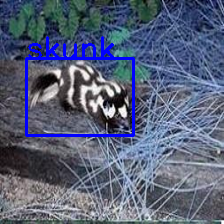

In [54]:

if __name__=="__main__":
    # Para paralelizar el código, se necesitará una función que debe ser la "tarea" a asignar para cada proceso:
    train_path = "/content/train"
    test_path = "/content/test"

    # Se crean los arreglos donde se almacenarán las imágenes, targets (bounding boxes) y la clase
    imagenes_train = []
    targets_train = []
    clase_train = []

    imagenes_test = []
    targets_test = []
    clase_test = []

    # Obtenemos las rutas de solo los archivos xml para la lectura de los mismos
    xml_rutas_train = sorted(
        [os.path.join(train_path, direct) for direct in os.listdir(train_path) if direct.endswith(".xml")])
    xml_rutas_test = sorted(
        [os.path.join(test_path, direct) for direct in os.listdir(test_path) if direct.endswith(".xml")])

    #Distribuiyendo el procesamiento de imágenes utilizando técnicas de paralelismo: concurrent.futures para distribuir el procesamiento de imágenes en múltiples núcleos de CPU
    with futures.ProcessPoolExecutor() as executor:
        #A cada proceso se le asigna una ruta para que la lea y se haga el procesamiento
        for ruta in xml_rutas_train:
            l=executor.submit(Data,ruta)
            #Almacenamos el resultado de cada tarea hecha por cada proceso en las listas "targets" y "clase"
            targets_train.extend(l.result()[0]) #el índice 0 de la variable 'l' hace referencia al bounding box
            clase_train.extend(l.result()[1])   #el índice 1 de la variable 'l' hace referencia a la clase
            imagenes_train.extend(np.array(l.result()[2])) #el índice 2 de la variable 'l' hace referencia a la imagen (en array)


    #Se realiza lo mismo para la data de test
    with futures.ProcessPoolExecutor() as executor:
        for ruta in xml_rutas_test:
            l=executor.submit(Data,ruta)
            targets_test.extend(l.result()[0])
            clase_test.extend(l.result()[1])
            imagenes_test.extend(np.array(l.result()[2])) #En array

    #Finalmente, para ver si se guardó en las listas "targets" y "clase", se imprimirá su longitud, que debería ser mayor a 0
    print("Tamaño de targets_train:",len(targets_train))
    print("Tamaño de clase_train",len(clase_train))
    print("Tamaño de imagenes_train",len(imagenes_train))

    print("Tamaño de targets_test",len(targets_test))
    print("Tamaño de clase_test",len(clase_test))
    print("Tamaño de imagenes_test",len(imagenes_test))

    print("-----------")

##------------------##
    print("Imagen de muestra de la data ya procesada:")

    #Una vez que la data ya se tiene, se convertirán a arreglos de numpy
    targets_train=np.array(targets_train)
    clase_train=np.array(clase_train)
    imagenes_train=np.array(imagenes_train)

    targets_test=np.array(targets_test)
    clase_test=np.array(clase_test)
    imagenes_test=np.array(imagenes_test)


    #Se mostrará 1 imagen, su bounding box y clase para ver si son los datos correctos
    from google.colab.patches import cv2_imshow

    img_prueba=imagenes_train[20]
    target_prueba=targets_train[20]
    clase_prueba=clase_train[20]

    img_prueba=cv2.rectangle(img_prueba,(target_prueba[0],target_prueba[1]),(target_prueba[2],target_prueba[3]),(255,0,0),2)
    img_prueba=cv2.putText(img_prueba,clases[clase_prueba],(target_prueba[0],target_prueba[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
    cv2_imshow(img_prueba)

